In [9]:
# GeneLab AI/ML AWG RR9 - Digital Twin Project - Scripts for RNA-Seq Data Analysis
# Version: 2024-03-14
# Author: Casaletto, James A. (ARC-SCR)[Blue Marble Space], james.a.casaletto@nasa.gov
# Updated by Dr. Jian Gong (University of Wyoming), jgong@uwyo.edu (email for questions and comments)

import os
import numpy as np
import pandas as pd
import scanpy as sc
import gseapy as gp

# PyDESeq2: Differential gene expression analysis based on the negative binomial distribution
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

# GSEAPY: Gene Set Enrichment Analysis in Python
from gseapy.plot import gseaplot
from gseapy import Msigdb

from pybiomart import Server
import mygene

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 4000) # Modify this value to best fit your screen/editor
pd.set_option('display.max_colwidth', 100) # Use this option to display the full content of columns

from pprint import pprint as pp


In [16]:
# Reading data for OSD-255

df_osd_255 = pd.read_csv(os.path.join('data', 'OSD-255', 'GLDS-255_rna_seq_RSEM_Unnormalized_Counts.csv'), header=0, sep=',')
meta_osd_255 = pd.read_csv(os.path.join('data', 'OSD-255', 'metadata', 's_OSD-255.txt'), header=0, sep='\t')

print("Number of genes: " + str(len(df_osd_255)))
print(df_osd_255.head())

print("Number of samples: " + str(len(meta_osd_255)))
print(meta_osd_255.head())


Number of genes: 56840
           Unnamed: 0  GSM3932693  GSM3932694  GSM3932695  GSM3932696  GSM3932697  GSM3932698  GSM3932699  GSM3932700  GSM3932701  GSM3932702  GSM3932703  GSM3932704  GSM3932705  GSM3932706  GSM3932707  GSM3932708
0  ENSMUSG00000000001       226.0       288.0       316.0       252.0       176.0       244.0       291.0       247.0       242.0       256.0       249.0       241.0       188.0       273.0       242.0       288.0
1  ENSMUSG00000000003         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0
2  ENSMUSG00000000028        24.0        38.0        34.0        29.0        10.0        22.0        29.0        35.0        32.0        42.0        30.0        22.0        19.0        25.0        24.0        44.0
3  ENSMUSG00000000031         9.0         2.0         3.0        27.0         0.0         3.0         7.0         8.0    

In [11]:
# Inspect meta_osd_255

pp(set(meta_osd_255['Characteristics[Strain]']))
pp(set(meta_osd_255['Characteristics[Animal Source]']))
pp(set(meta_osd_255['Characteristics[Age at Launch]']))
pp(set(meta_osd_255['Comment[Feeding Schedule]']))
pp(set(meta_osd_255['Factor Value[Spaceflight]']))
pp(set(meta_osd_255['Parameter Value[Euthanasia Method]']))
pp(set(meta_osd_255['Parameter Value[Sample Preservation Method]']))
pp(set(meta_osd_255['Source Name']))

meta = meta_osd_255

{'C57BL/6J'}
{'Jackson Laboratory'}
{10}
{'ad libitum'}
{'Ground Control', 'Space Flight'}
{'Carbon Dioxide'}
{'Liquid Nitrogen'}
{'Retina_Flight_11',
 'Retina_Flight_15',
 'Retina_Flight_16',
 'Retina_Flight_17',
 'Retina_Flight_18',
 'Retina_Flight_19',
 'Retina_Flight_20',
 'Retina_Flight_9',
 'Retina_Ground Control_11',
 'Retina_Ground Control_15',
 'Retina_Ground Control_16',
 'Retina_Ground Control_17',
 'Retina_Ground Control_18',
 'Retina_Ground Control_19',
 'Retina_Ground Control_20',
 'Retina_Ground Control_9'}


### Filter and Clean Data

In [17]:
# Filter data by droping NaN rows

print(len(df_osd_255))
df_osd_255.dropna(inplace=True)
print(len(df_osd_255))

56840
56840


In [18]:
# Drop any low-count genes

threshold=10
print(len(df_osd_255))
if 'transcript' in df_osd_255.columns:
    df_osd_255 = df_osd_255[df_osd_255.drop(columns=['transcript']).sum(axis=1) >= threshold]
elif 'Unnamed: 0' in df_osd_255.columns:
    df_osd_255 = df_osd_255[df_osd_255.drop(columns=['Unnamed: 0']).sum(axis=1) >= threshold]
    df_osd_255.rename(columns={"Unnamed: 0":"transcript"}, inplace=True)
else:
    raise Exception("check file format")
print(len(df_osd_255))

56840
23747


In [19]:
# Drop any non-protein-coding genes

server = Server(host='http://www.ensembl.org')
dataset = (server.marts['ENSEMBL_MART_ENSEMBL'].datasets['mmusculus_gene_ensembl'])
gene_info = dataset.query(attributes=['ensembl_gene_id', 'external_gene_name', 'gene_biotype'])
filter_genes=gene_info[gene_info['Gene type'] == 'protein_coding']['Gene stable ID']

print(len(df_osd_255))
df_osd_255=df_osd_255[df_osd_255['transcript'].isin(filter_genes)]
print(len(df_osd_255))

df = df_osd_255

23747
15963


In [20]:
# Convert gene id to gene symbol
# Remove any genes that do not have a gene symbol

mg=mygene.MyGeneInfo()
ens=list(df['transcript'])
ginfo = mg.querymany(ens, scopes='ensembl.gene')
drop_list=list()
hit_list=list()
for g in ginfo:
    if not 'symbol' in g:
        drop_list.append(g['query'])
    else:
        if not g['symbol'] in hit_list:
            df.loc[df['transcript']==g['query'], 'transcript']=g['symbol']
            hit_list.append(g['symbol'])

print(len(df))
df=df[~df['transcript'].isin(drop_list)]
print(len(df))

1 input query terms found no hit:	['ENSMUSG00000034007']


15963
15960


### transpose dataframe

In [27]:
dfT = df.T
dfT.head()

,0,2,4,5,6,7,8,9,10,11,...,52385,52386,52387,52389,52390,52391,52393,52394,53476,55838
transcript,Gnai3,Cdc45,Scml2,Apoh,Narf,Cav2,Klf6,Scmh1,Cox5a,Tbx2,...,Afg2b,Tusc3,Lin54,Ahnak2,Rps6ka4,Arvcf,Eppk1,Muc4,Zfp33b,Klhl17
GSM3932693,226.0,24.0,10.0,2.0,459.0,236.0,223.0,569.0,667.0,614.0,...,75.0,704.0,250.0,595.0,89.1,275.0,13.0,2.0,140.82,149.04
GSM3932694,288.0,38.0,23.0,3.0,623.0,252.0,321.0,642.0,945.0,722.0,...,92.0,731.0,247.0,677.0,98.36,728.0,22.0,176.0,176.17,166.25
GSM3932695,316.0,34.0,25.0,1.0,724.0,359.0,324.0,755.0,1134.0,880.0,...,121.0,985.0,278.0,494.0,171.19,515.0,24.0,3.0,187.55,260.86
GSM3932696,252.0,29.0,29.0,6.0,605.0,299.0,313.0,594.0,974.0,682.0,...,86.0,830.0,244.0,603.0,112.82,332.0,39.0,850.0,160.88,205.46


In [28]:
dfT.columns=dfT.iloc[0]
dfT.head()

transcript,Gnai3,Cdc45,Scml2,Apoh,Narf,Cav2,Klf6,Scmh1,Cox5a,Tbx2,...,Afg2b,Tusc3,Lin54,Ahnak2,Rps6ka4,Arvcf,Eppk1,Muc4,Zfp33b,Klhl17
transcript,Gnai3,Cdc45,Scml2,Apoh,Narf,Cav2,Klf6,Scmh1,Cox5a,Tbx2,...,Afg2b,Tusc3,Lin54,Ahnak2,Rps6ka4,Arvcf,Eppk1,Muc4,Zfp33b,Klhl17
GSM3932693,226.0,24.0,10.0,2.0,459.0,236.0,223.0,569.0,667.0,614.0,...,75.0,704.0,250.0,595.0,89.1,275.0,13.0,2.0,140.82,149.04
GSM3932694,288.0,38.0,23.0,3.0,623.0,252.0,321.0,642.0,945.0,722.0,...,92.0,731.0,247.0,677.0,98.36,728.0,22.0,176.0,176.17,166.25
GSM3932695,316.0,34.0,25.0,1.0,724.0,359.0,324.0,755.0,1134.0,880.0,...,121.0,985.0,278.0,494.0,171.19,515.0,24.0,3.0,187.55,260.86
GSM3932696,252.0,29.0,29.0,6.0,605.0,299.0,313.0,594.0,974.0,682.0,...,86.0,830.0,244.0,603.0,112.82,332.0,39.0,850.0,160.88,205.46


In [29]:
dfT=dfT.iloc[1:]
dfT.head()

transcript,Gnai3,Cdc45,Scml2,Apoh,Narf,Cav2,Klf6,Scmh1,Cox5a,Tbx2,...,Afg2b,Tusc3,Lin54,Ahnak2,Rps6ka4,Arvcf,Eppk1,Muc4,Zfp33b,Klhl17
GSM3932693,226.0,24.0,10.0,2.0,459.0,236.0,223.0,569.0,667.0,614.0,...,75.0,704.0,250.0,595.0,89.1,275.0,13.0,2.0,140.82,149.04
GSM3932694,288.0,38.0,23.0,3.0,623.0,252.0,321.0,642.0,945.0,722.0,...,92.0,731.0,247.0,677.0,98.36,728.0,22.0,176.0,176.17,166.25
GSM3932695,316.0,34.0,25.0,1.0,724.0,359.0,324.0,755.0,1134.0,880.0,...,121.0,985.0,278.0,494.0,171.19,515.0,24.0,3.0,187.55,260.86
GSM3932696,252.0,29.0,29.0,6.0,605.0,299.0,313.0,594.0,974.0,682.0,...,86.0,830.0,244.0,603.0,112.82,332.0,39.0,850.0,160.88,205.46
GSM3932697,176.0,10.0,11.0,1.0,509.0,209.0,272.0,513.0,758.0,582.0,...,60.0,535.0,222.0,431.0,111.1,278.0,14.0,17.0,128.97,135.33


In [30]:
dfT.columns.name=None
dfT.head()

,Gnai3,Cdc45,Scml2,Apoh,Narf,Cav2,Klf6,Scmh1,Cox5a,Tbx2,...,Afg2b,Tusc3,Lin54,Ahnak2,Rps6ka4,Arvcf,Eppk1,Muc4,Zfp33b,Klhl17
GSM3932693,226.0,24.0,10.0,2.0,459.0,236.0,223.0,569.0,667.0,614.0,...,75.0,704.0,250.0,595.0,89.1,275.0,13.0,2.0,140.82,149.04
GSM3932694,288.0,38.0,23.0,3.0,623.0,252.0,321.0,642.0,945.0,722.0,...,92.0,731.0,247.0,677.0,98.36,728.0,22.0,176.0,176.17,166.25
GSM3932695,316.0,34.0,25.0,1.0,724.0,359.0,324.0,755.0,1134.0,880.0,...,121.0,985.0,278.0,494.0,171.19,515.0,24.0,3.0,187.55,260.86
GSM3932696,252.0,29.0,29.0,6.0,605.0,299.0,313.0,594.0,974.0,682.0,...,86.0,830.0,244.0,603.0,112.82,332.0,39.0,850.0,160.88,205.46
GSM3932697,176.0,10.0,11.0,1.0,509.0,209.0,272.0,513.0,758.0,582.0,...,60.0,535.0,222.0,431.0,111.1,278.0,14.0,17.0,128.97,135.33


In [31]:
dfT = dfT.reset_index().rename(columns={"index":"sample"})
dfT.head()

,sample,Gnai3,Cdc45,Scml2,Apoh,Narf,Cav2,Klf6,Scmh1,Cox5a,...,Afg2b,Tusc3,Lin54,Ahnak2,Rps6ka4,Arvcf,Eppk1,Muc4,Zfp33b,Klhl17
0,GSM3932693,226.0,24.0,10.0,2.0,459.0,236.0,223.0,569.0,667.0,...,75.0,704.0,250.0,595.0,89.1,275.0,13.0,2.0,140.82,149.04
1,GSM3932694,288.0,38.0,23.0,3.0,623.0,252.0,321.0,642.0,945.0,...,92.0,731.0,247.0,677.0,98.36,728.0,22.0,176.0,176.17,166.25
2,GSM3932695,316.0,34.0,25.0,1.0,724.0,359.0,324.0,755.0,1134.0,...,121.0,985.0,278.0,494.0,171.19,515.0,24.0,3.0,187.55,260.86
3,GSM3932696,252.0,29.0,29.0,6.0,605.0,299.0,313.0,594.0,974.0,...,86.0,830.0,244.0,603.0,112.82,332.0,39.0,850.0,160.88,205.46
4,GSM3932697,176.0,10.0,11.0,1.0,509.0,209.0,272.0,513.0,758.0,...,60.0,535.0,222.0,431.0,111.1,278.0,14.0,17.0,128.97,135.33


In [32]:
len(dfT.columns)

15961

In [33]:
len(set(dfT.columns))

15961

### differential gene expression analysis
### https://pydeseq2.readthedocs.io/en/latest/auto_examples/plot_minimal_pydeseq2_pipeline.html

In [35]:
# now let's create a df for 'Factor Value[Spaceflight]'
condition_dict=dict()
for sample in list(dfT['sample']):
    val=meta[meta['Sample Name']==sample]['Factor Value[Spaceflight]'].values[0]
    if val == 'Ground Control':
        condition_dict[sample] = 0
    else:
        condition_dict[sample] = 1
dfT["condition"] = dfT["sample"].map(condition_dict)
conditions=dfT[['sample', 'condition']]

In [36]:
conditions

,sample,condition
0,GSM3932693,0
1,GSM3932694,0
2,GSM3932695,0
3,GSM3932696,0
4,GSM3932697,0
5,GSM3932698,0
6,GSM3932699,0
7,GSM3932700,0
8,GSM3932701,1
9,GSM3932702,1


In [37]:
counts=dfT.drop(columns=['sample', 'condition']).reset_index(drop=True)
counts.head()

,Gnai3,Cdc45,Scml2,Apoh,Narf,Cav2,Klf6,Scmh1,Cox5a,Tbx2,...,Afg2b,Tusc3,Lin54,Ahnak2,Rps6ka4,Arvcf,Eppk1,Muc4,Zfp33b,Klhl17
0,226.0,24.0,10.0,2.0,459.0,236.0,223.0,569.0,667.0,614.0,...,75.0,704.0,250.0,595.0,89.1,275.0,13.0,2.0,140.82,149.04
1,288.0,38.0,23.0,3.0,623.0,252.0,321.0,642.0,945.0,722.0,...,92.0,731.0,247.0,677.0,98.36,728.0,22.0,176.0,176.17,166.25
2,316.0,34.0,25.0,1.0,724.0,359.0,324.0,755.0,1134.0,880.0,...,121.0,985.0,278.0,494.0,171.19,515.0,24.0,3.0,187.55,260.86
3,252.0,29.0,29.0,6.0,605.0,299.0,313.0,594.0,974.0,682.0,...,86.0,830.0,244.0,603.0,112.82,332.0,39.0,850.0,160.88,205.46
4,176.0,10.0,11.0,1.0,509.0,209.0,272.0,513.0,758.0,582.0,...,60.0,535.0,222.0,431.0,111.1,278.0,14.0,17.0,128.97,135.33


In [38]:
# check for non-numeric
counts.applymap(np.isreal)

,Gnai3,Cdc45,Scml2,Apoh,Narf,Cav2,Klf6,Scmh1,Cox5a,Tbx2,...,Afg2b,Tusc3,Lin54,Ahnak2,Rps6ka4,Arvcf,Eppk1,Muc4,Zfp33b,Klhl17
0,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
5,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
6,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
7,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
8,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
9,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [39]:
# convert all cells to integers
counts=counts.astype(int)
counts

,Gnai3,Cdc45,Scml2,Apoh,Narf,Cav2,Klf6,Scmh1,Cox5a,Tbx2,...,Afg2b,Tusc3,Lin54,Ahnak2,Rps6ka4,Arvcf,Eppk1,Muc4,Zfp33b,Klhl17
0,226,24,10,2,459,236,223,569,667,614,...,75,704,250,595,89,275,13,2,140,149
1,288,38,23,3,623,252,321,642,945,722,...,92,731,247,677,98,728,22,176,176,166
2,316,34,25,1,724,359,324,755,1134,880,...,121,985,278,494,171,515,24,3,187,260
3,252,29,29,6,605,299,313,594,974,682,...,86,830,244,603,112,332,39,850,160,205
4,176,10,11,1,509,209,272,513,758,582,...,60,535,222,431,111,278,14,17,128,135
5,244,22,19,5,637,259,353,658,867,671,...,90,802,242,539,100,323,3,12,157,163
6,291,29,12,4,672,345,368,802,933,863,...,117,932,298,651,131,460,22,62,171,213
7,247,35,25,0,581,273,314,653,895,691,...,96,852,279,632,136,412,11,187,150,191
8,242,32,21,0,593,286,286,568,1005,703,...,118,875,279,403,129,378,16,13,161,190
9,256,42,15,1,604,264,410,656,963,736,...,93,759,316,812,111,328,92,2531,139,188


In [40]:
dds=DeseqDataSet(counts=counts, metadata=conditions, design_factors="condition")

/home/gojian/Programs/Mamba/envs/awg/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [45]:
dds.deseq2()


Fitting size factors...
... done in 0.01 seconds.



Fitting dispersions...
... done in 0.68 seconds.

Fitting dispersion trend curve...
... done in 0.21 seconds.

Fitting MAP dispersions...
... done in 0.70 seconds.

Fitting LFCs...
... done in 0.67 seconds.

Replacing 275 outlier genes.

Fitting dispersions...
... done in 0.05 seconds.

Fitting MAP dispersions...
... done in 0.07 seconds.

Fitting LFCs...
... done in 0.09 seconds.



In [46]:
stats_results=DeseqStats(dds, contrast = ('condition', '0', '1'))

In [47]:
stats_results.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition 0 vs 1
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Gnai3   248.572433       -0.024547  0.068870 -0.356427  0.721521  0.921068
Cdc45    28.136334       -0.176248  0.216183 -0.815271  0.414917       NaN
Scml2    18.361029        0.006594  0.282763  0.023319  0.981396       NaN
Apoh      1.701630        1.833677  0.906330  2.023189  0.043054       NaN
Narf    601.585964       -0.091815  0.052484 -1.749404  0.080221  0.404324
...            ...             ...       ...       ...       ...       ...
Arvcf   383.629781        0.106019  0.147901  0.716827  0.473481  0.815471
Eppk1    16.244925        0.272188  0.334575  0.813535  0.415911       NaN
Muc4     39.650660        1.476076  0.716688  2.059579  0.039439  0.280849
Zfp33b  153.731469        0.004333  0.096643  0.044835  0.964239  0.990736
Klhl17  180.368716       -0.028859  0.096368 -0.299471  0.764580  0.937085

[15960 rows x 6 columns]


... done in 0.49 seconds.



In [48]:
res = stats_results.results_df

In [49]:
res

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gnai3,248.572433,-0.024547,0.068870,-0.356427,0.721521,0.921068
Cdc45,28.136334,-0.176248,0.216183,-0.815271,0.414917,NaN
Scml2,18.361029,0.006594,0.282763,0.023319,0.981396,NaN
Apoh,1.701630,1.833677,0.906330,2.023189,0.043054,NaN
Narf,601.585964,-0.091815,0.052484,-1.749404,0.080221,0.404324
...,...,...,...,...,...,...
Arvcf,383.629781,0.106019,0.147901,0.716827,0.473481,0.815471
Eppk1,16.244925,0.272188,0.334575,0.813535,0.415911,NaN
Muc4,39.650660,1.476076,0.716688,2.059579,0.039439,0.280849
Zfp33b,153.731469,0.004333,0.096643,0.044835,0.964239,0.990736


In [50]:
res = res[res.baseMean >= 10]
res

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gnai3,248.572433,-0.024547,0.068870,-0.356427,0.721521,0.921068
Cdc45,28.136334,-0.176248,0.216183,-0.815271,0.414917,NaN
Scml2,18.361029,0.006594,0.282763,0.023319,0.981396,NaN
Narf,601.585964,-0.091815,0.052484,-1.749404,0.080221,0.404324
Cav2,278.946302,-0.097729,0.075494,-1.294530,0.195482,0.596084
...,...,...,...,...,...,...
Arvcf,383.629781,0.106019,0.147901,0.716827,0.473481,0.815471
Eppk1,16.244925,0.272188,0.334575,0.813535,0.415911,NaN
Muc4,39.650660,1.476076,0.716688,2.059579,0.039439,0.280849
Zfp33b,153.731469,0.004333,0.096643,0.044835,0.964239,0.990736


In [51]:
sigs0 = res[(res.padj < 0.05) & (abs(res.log2FoldChange) > 0)]
sigs0

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Mnt,602.404543,0.182095,0.050855,3.580674,3.427084e-04,1.377180e-02
Cdh4,515.481071,0.195105,0.054970,3.549287,3.862761e-04,1.506603e-02
Ckmt1,869.861931,-0.216243,0.058060,-3.724499,1.957033e-04,9.171739e-03
Hk2,7791.845654,-0.310585,0.062857,-4.941148,7.766380e-07,1.103473e-04
Scn4a,160.635954,-0.511232,0.101167,-5.053324,4.341871e-07,6.643619e-05
...,...,...,...,...,...,...
Frmpd2,1303.479149,-0.367915,0.059157,-6.219258,4.995103e-10,1.753428e-07
Gm19410,40.601367,-0.675043,0.193756,-3.483978,4.940205e-04,1.855797e-02
Smim36,671.729602,-0.208747,0.052484,-3.977350,6.968747e-05,4.280355e-03
ENSMUSG00000115018,36.627173,0.730179,0.221793,3.292163,9.942003e-04,3.090047e-02


In [52]:
sigs10 = res[(res.padj < 0.05) & (abs(res.log2FoldChange) > 1.0)]
sigs10

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Irf7,204.395220,-1.572677,0.107503,-14.629129,1.831166e-48,1.092749e-44
Pagr1a,45.418177,2.357489,0.750853,3.139747,1.690940e-03,4.455049e-02


In [53]:
dds

AnnData object with n_obs × n_vars = 16 × 15960
    obs: 'sample', 'condition'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks', 'replace_cooks'

/home/gojian/Programs/Mamba/envs/awg/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


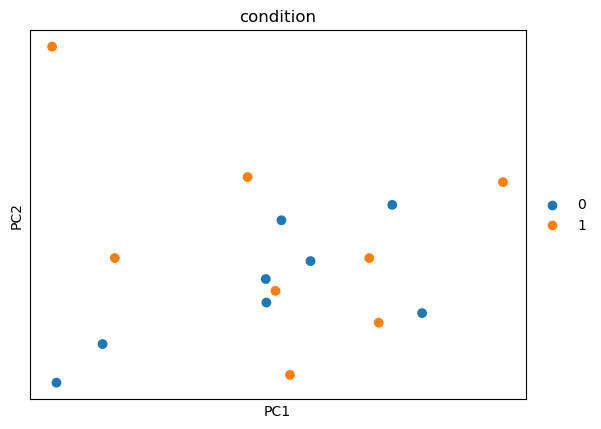

In [54]:
# let's plot PCA
sc.tl.pca(dds)
sc.pl.pca(dds, color='condition', size=200)

### gene set enrichment analysis
### https://gseapy.readthedocs.io/en/latest/introduction.html

In [55]:
# let's do GSEA

ranking = res[['stat']].dropna().sort_values('stat', ascending=False)
ranking

,stat
Sag,12.239699
Pdzph1,11.514435
Glmn,10.850764
Cpt1a,10.825940
Dyrk2,8.504702
...,...
H2bc4,-8.924846
Ide,-9.865796
Hsp90aa1,-11.683045
Irf7,-14.629129


In [56]:
ranking_index=list(ranking.index)
ranking_index_upper=[x.upper() for x in ranking_index]
ranking.index=ranking_index_upper
ranking

,stat
SAG,12.239699
PDZPH1,11.514435
GLMN,10.850764
CPT1A,10.825940
DYRK2,8.504702
...,...
H2BC4,-8.924846
IDE,-9.865796
HSP90AA1,-11.683045
IRF7,-14.629129


In [57]:
gp.get_library_name()

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
 'Descartes_Cell_Types_and_Tissue_2021',
 'Diabetes_Perturbations_GEO_2022',
 'DisG

In [58]:
pre_res = gp.prerank(rnk=ranking, gene_sets=['GO_Biological_Process_2023'], seed=23, permutation_num=100)
pre_res.res2d[pre_res.res2d['FWER p-val'] < 0.05]

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,GO_Biological_Process_2023__Cytoplasmic Transl...,-0.600876,-2.552217,0.0,0.0,0.0,46/90,19.50%,RPL30;RACK1;RPS21;RPL34;RPL3;RPL18A;RPS26;RPL2...
1,prerank,GO_Biological_Process_2023__Response To Unfold...,-0.623389,-2.204551,0.0,0.003369,0.01,8/39,2.51%,HSP90AA1;HSPA8;DNAJB2;PACRG;OPTN;DNAJB4;HSPH1;...
2,prerank,GO_Biological_Process_2023__Regulation Of Neur...,0.640181,2.161125,0.0,0.013052,0.01,16/38,11.97%,LYNX1;NPTX1;NPTXR;NETO1;CACNG4;CACNG7;RELN;DLG...
3,prerank,GO_Biological_Process_2023__Positive Regulatio...,0.749868,2.159004,0.0,0.006526,0.01,8/15,6.75%,NR4A3;AKAP6;CAMK2D;PDE9A;MTPN;PRKCA;PARP1;SLC9A1
4,prerank,GO_Biological_Process_2023__L-amino Acid Trans...,0.729543,2.094149,0.0,0.013052,0.03,14/19,21.07%,SLC7A5;SLC7A1;SLC38A1;SLC3A2;SLC7A8;SLC6A17;SL...


In [59]:
pre_res = gp.prerank(rnk=ranking, gene_sets='GO_Molecular_Function_2023', seed=23, permutation_num=100)
pre_res.res2d[pre_res.res2d['FWER p-val'] < 0.05]

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,aminoacyl-tRNA Ligase Activity (GO:0004812),0.591675,2.097054,0.0,0.0,0.0,18/37,18.46%,GARS1;EPRS1;IARS1;LRRC47;SARS1;LARS1;VARS1;CAR...


In [60]:
pre_res = gp.prerank(rnk=ranking, gene_sets='GO_Cellular_Component_2023', seed=23, permutation_num=100)
pre_res.res2d[pre_res.res2d['FWER p-val'] < 0.05]

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Large Ribosomal Subunit (GO:0015934),-0.664407,-2.28794,0.0,0.003409,0.01,23/46,16.80%,RPL30;RPL34;RPL3;RPL18A;RPL27A;RPL32;RPL9;RPL3...
1,prerank,Cytosolic Large Ribosomal Subunit (GO:0022625),-0.664407,-2.28794,0.0,0.003409,0.01,23/46,16.80%,RPL30;RPL34;RPL3;RPL18A;RPL27A;RPL32;RPL9;RPL3...
2,prerank,Small Ribosomal Subunit (GO:0015935),-0.636872,-2.254058,0.0,0.002273,0.01,22/36,21.66%,RACK1;RPS21;RPS26;RPS19;RPS20;RPS27;RPS16;RPS8...
3,prerank,Cytosolic Small Ribosomal Subunit (GO:0022627),-0.651114,-2.223249,0.0,0.001705,0.01,19/35,15.72%,RACK1;RPS21;RPS26;RPS19;RPS20;RPS27;RPS16;RPS8...
4,prerank,Ribosome (GO:0005840),-0.531167,-2.148791,0.0,0.001364,0.01,24/57,16.80%,RPL30;RPS21;RPL18A;NUFIP2;RPS26;RPL32;RPL9;RPS...


In [61]:
pre_res = gp.prerank(rnk=ranking, gene_sets='KEGG_2019_Mouse', seed=23, permutation_num=100)
pre_res.res2d[pre_res.res2d['FWER p-val'] < 0.05]

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Ribosome,-0.537116,-2.439996,0.0,0.0,0.0,50/127,16.92%,RPL30;RPS21;RPL34;RPL3;RPL18A;RPS3A1;RPS26;RPL...
1,prerank,Antigen processing and presentation,-0.59282,-2.103823,0.0,0.004285,0.01,9/40,2.45%,HSP90AA1;HSPA8;HSPA5;LGMN;PDIA3;CREB1;CALR;NFY...


In [62]:
pre_res = gp.prerank(rnk=ranking, gene_sets=['GO_Biological_Process_2023', 'GO_Molecular_Function_2023', 'GO_Cellular_Component_2023', 'KEGG_2019_Mouse'], seed=23, permutation_num=100)
pre_res.res2d[pre_res.res2d['FWER p-val'] < 0.05]

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,GO_Biological_Process_2023__Cytoplasmic Transl...,-0.600876,-2.552217,0.0,0.0,0.0,46/90,19.50%,RPL30;RACK1;RPS21;RPL34;RPL3;RPL18A;RPS26;RPL2...
1,prerank,KEGG_2019_Mouse__Ribosome,-0.537116,-2.439996,0.0,0.0,0.0,50/127,16.92%,RPL30;RPS21;RPL34;RPL3;RPL18A;RPS3A1;RPS26;RPL...
2,prerank,GO_Cellular_Component_2023__Cytosolic Large Ri...,-0.664407,-2.28794,0.0,0.001741,0.01,23/46,16.80%,RPL30;RPL34;RPL3;RPL18A;RPL27A;RPL32;RPL9;RPL3...
3,prerank,GO_Cellular_Component_2023__Large Ribosomal Su...,-0.664407,-2.28794,0.0,0.001741,0.01,23/46,16.80%,RPL30;RPL34;RPL3;RPL18A;RPL27A;RPL32;RPL9;RPL3...
4,prerank,GO_Cellular_Component_2023__Small Ribosomal Su...,-0.636872,-2.254058,0.0,0.001393,0.01,22/36,21.66%,RACK1;RPS21;RPS26;RPS19;RPS20;RPS27;RPS16;RPS8...
5,prerank,GO_Cellular_Component_2023__Cytosolic Small Ri...,-0.651114,-2.223249,0.0,0.002321,0.02,19/35,15.72%,RACK1;RPS21;RPS26;RPS19;RPS20;RPS27;RPS16;RPS8...
6,prerank,GO_Biological_Process_2023__Response To Unfold...,-0.623389,-2.204551,0.0,0.002985,0.03,8/39,2.51%,HSP90AA1;HSPA8;DNAJB2;PACRG;OPTN;DNAJB4;HSPH1;...
7,prerank,GO_Biological_Process_2023__Regulation Of Neur...,0.640181,2.161125,0.0,0.012816,0.01,16/38,11.97%,LYNX1;NPTX1;NPTXR;NETO1;CACNG4;CACNG7;RELN;DLG...
8,prerank,GO_Biological_Process_2023__Positive Regulatio...,0.749868,2.159004,0.0,0.006408,0.01,8/15,6.75%,NR4A3;AKAP6;CAMK2D;PDE9A;MTPN;PRKCA;PARP1;SLC9A1
11,prerank,GO_Molecular_Function_2023__aminoacyl-tRNA Lig...,0.591675,2.097054,0.0,0.012816,0.03,18/37,18.46%,GARS1;EPRS1;IARS1;LRRC47;SARS1;LARS1;VARS1;CAR...


In [ ]:
# all data so far is osd-255 (rna-seq)
# all this was RSEM right?
# now try with STAR
# then try with normalized counts (osdr and my own)
# try with R DESeq2 and EdgeR

# read in the IOP data (osd-583)
# map IOP metadata sample names to df/dfT/... sample names (need ryan's help on this) --> 255:583
# now contrast high and low IOP values (what is high vs low?)

# try with soup2nuts + crisp


In [64]:
msig=Msigdb()
gmt=msig.get_gmt(category='mh.all', dbver="2023.1.Mm")
msig.list_dbver()


,Name,Last modified
0,6.0,2018-12-17 16:29
1,6.1,2018-12-17 16:29
2,6.2,2018-12-17 16:29
3,7.0,2020-01-27 04:43
4,7.1,2020-03-30 16:55
5,7.2,2020-09-18 23:33
6,7.3,2021-03-22 15:09
7,7.4,2021-04-02 14:38
8,7.5.1,2023-03-09 19:38
9,7.5,2022-01-13 01:00


In [65]:
msig.list_category(dbver="2023.1.Hs")

['c1.all',
 'c2.all',
 'c2.cgp',
 'c2.cp.biocarta',
 'c2.cp.kegg',
 'c2.cp.pid',
 'c2.cp.reactome',
 'c2.cp',
 'c2.cp.wikipathways',
 'c3.all',
 'c3.mir.mir_legacy',
 'c3.mir.mirdb',
 'c3.mir',
 'c3.tft.gtrd',
 'c3.tft.tft_legacy',
 'c3.tft',
 'c4.all',
 'c4.cgn',
 'c4.cm',
 'c5.all',
 'c5.go.bp',
 'c5.go.cc',
 'c5.go.mf',
 'c5.go',
 'c5.hpo',
 'c6.all',
 'c7.all',
 'c7.immunesigdb',
 'c7.vax',
 'c8.all',
 'h.all',
 'msigdb']